# Quick Start PyTorch - MNIST

To run a Code Cell you can click on the `⏯ Run` button in the Navigation Bar above or type `Shift + Enter`

In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# Device-agnostic code
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

print("TRAIN: %s \n\nTEST: %s" % (train, test))

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

TRAIN: Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None 

TEST: Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
# Statistic about Train data
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.to('cpu').numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Model

In [4]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    
    
    
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Train

Training time:

- CPU, about 1 minute and 30 seconds
- GPU, about 10 seconds

In [5]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = data.to(device), target.to(device)
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.to('cpu'))
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.to('cpu'), 
                end=''))
    # Eval
    evaluate_x = test_loader.dataset.data.to(device, dtype=torch.float)
    evaluate_y = test_loader.dataset.targets.to(device)
    
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).to('cpu', dtype=torch.float)
    accuracy = d.sum()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.to('cpu'),
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [256/60000 (0%)]	Loss: 2.113713
 Train Epoch: 1/5 [25856/60000 (43%)]	Loss: 0.200731
 Train Epoch: 1/5 [51456/60000 (86%)]	Loss: 0.181419
 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.149559	 Test Accuracy: 95.1800%
 Train Epoch: 2/5 [256/60000 (0%)]	Loss: 0.200559
 Train Epoch: 2/5 [25856/60000 (43%)]	Loss: 0.139539
 Train Epoch: 2/5 [51456/60000 (86%)]	Loss: 0.171719
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.134539	 Test Accuracy: 96.6800%
 Train Epoch: 3/5 [256/60000 (0%)]	Loss: 0.090054
 Train Epoch: 3/5 [25856/60000 (43%)]	Loss: 0.085397
 Train Epoch: 3/5 [51456/60000 (86%)]	Loss: 0.067546
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.090456	 Test Accuracy: 97.3200%
 Train Epoch: 4/5 [256/60000 (0%)]	Loss: 0.053138
 Train Epoch: 4/5 [25856/60000 (43%)]	Loss: 0.098433
 Train Epoch: 4/5 [51456/60000 (86%)]	Loss: 0.050530
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.039511	 Test Accuracy: 97.7400%
 Train Epoch: 5/5 [256/60000 (0%)]	Loss: 0.033713
 Train Epo

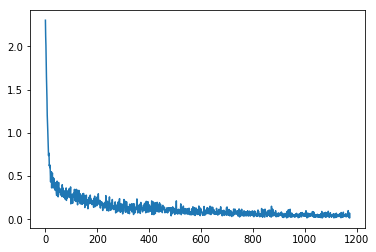

In [6]:
plot(losses)

## Evaluate

In [7]:
# Eval
evaluate_x = test_loader.dataset.data.to(device, dtype=torch.float)
evaluate_y = test_loader.dataset.targets.to(device)

model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).to('cpu', dtype=torch.float)
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(97.7800)
